In [1]:
# 어텐션을 시각화해서 vit 모델이 어떤 이미지(픽셀)에 집중하는지 확인해봄
# attention map         : 모델이 이미지의 어느 부분에 집중하는지
# patch embedding       : 이미지가 어떻게 작은 패치로 나누는지
# positional encoding   : 위치 정보가 어떻게 인코딩
# feature map           : 각 레이어에서 추출된 정보/특징


[1단계]모델 로드중...


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 : google/vit-base-patch16-224

[2단계] 이미지 로드 및 전처리 중....
원본 이미지 크기 : (960, 686)
전처리 후 텐서 크기 : torch.Size([1, 3, 224, 224])

[3단계] 모델 추론 중.....
레이어 수 : 12
어텐션 텐서 크기 : torch.Size([1, 12, 197, 197])
batch size	attention heads	sequence lenghth

[4단계] 어텐션 맵 시각화 중....
시각화 저장 완료: vit_attention_visualization.png

[5단계] 헤드별 어텐션 분석...
어텐션 헤드 수: 12
 헤드별 시각화 저장 완료: vit_attention_heads.png

[6단계] 레이어별 어텐션 패턴 분석...
  Layer 1: 평균 어텐션 = 0.0020
  Layer 2: 평균 어텐션 = 0.0026
  Layer 3: 평균 어텐션 = 0.0037
  Layer 4: 평균 어텐션 = 0.0044
  Layer 5: 평균 어텐션 = 0.0044
  Layer 6: 평균 어텐션 = 0.0049
  Layer 7: 평균 어텐션 = 0.0050
  Layer 8: 평균 어텐션 = 0.0051
  Layer 9: 평균 어텐션 = 0.0051
  Layer 10: 평균 어텐션 = 0.0051
  Layer 11: 평균 어텐션 = 0.0051
  Layer 12: 평균 어텐션 = 0.0051
 레이어별 분석 저장 완료: vit_attention_by_layer.png
시각화 완료!


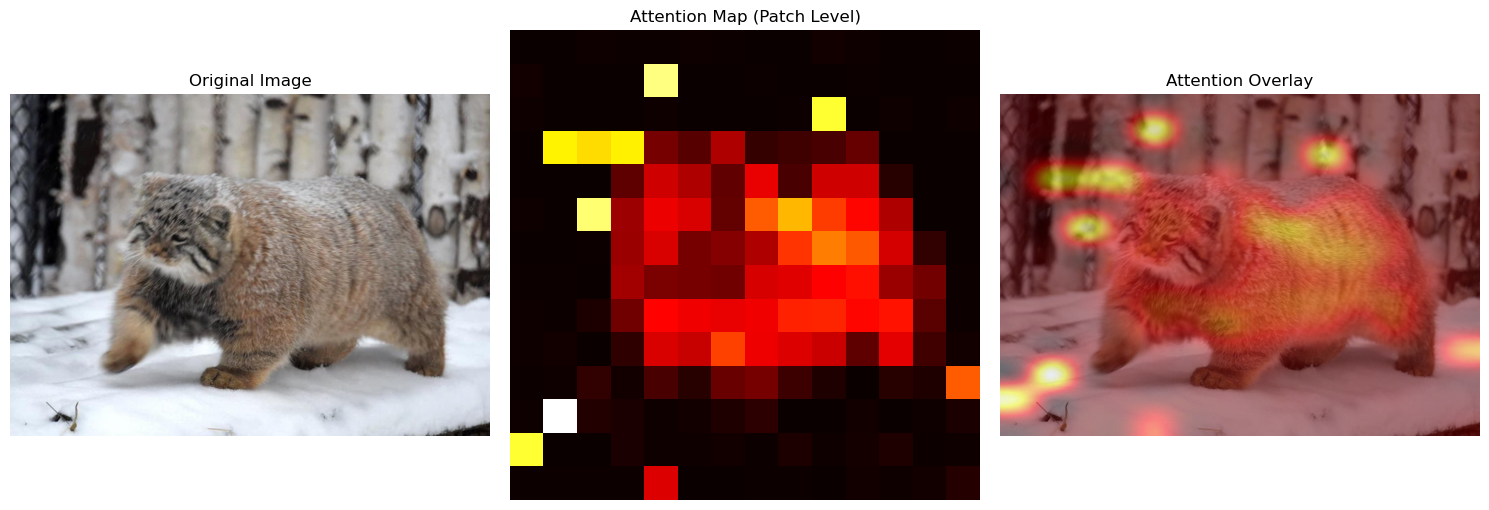

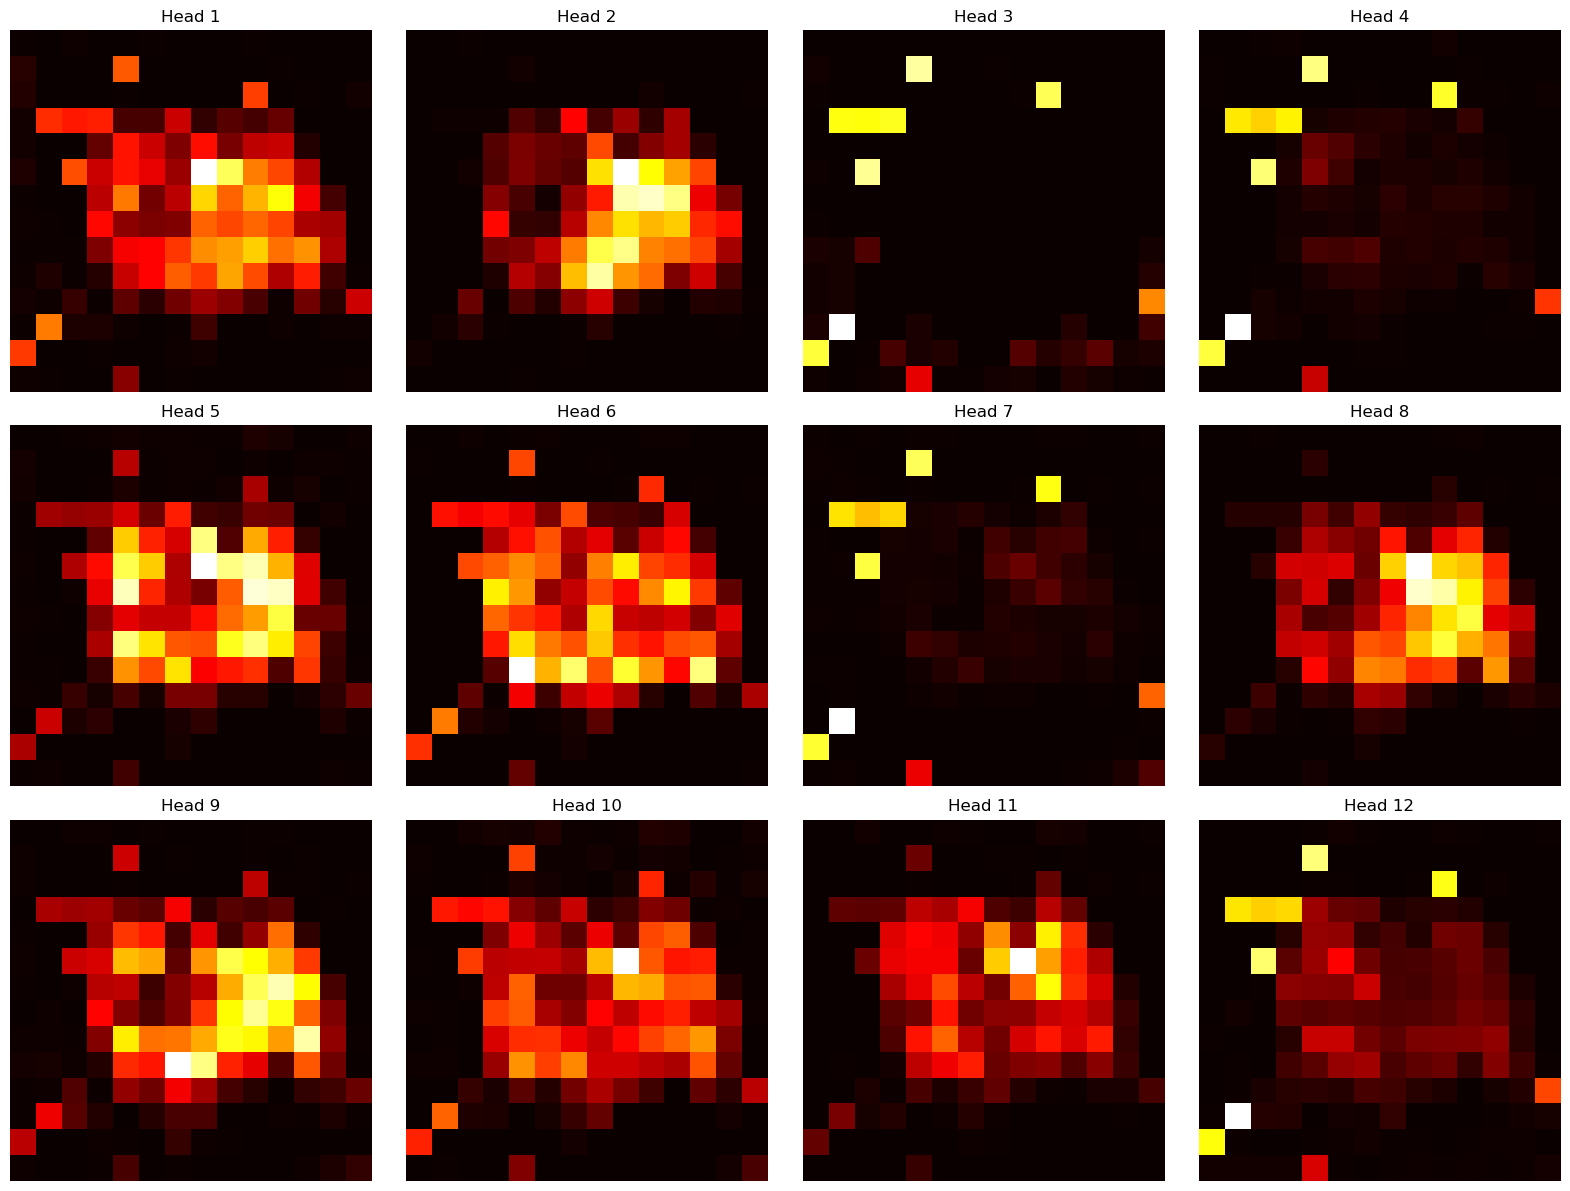

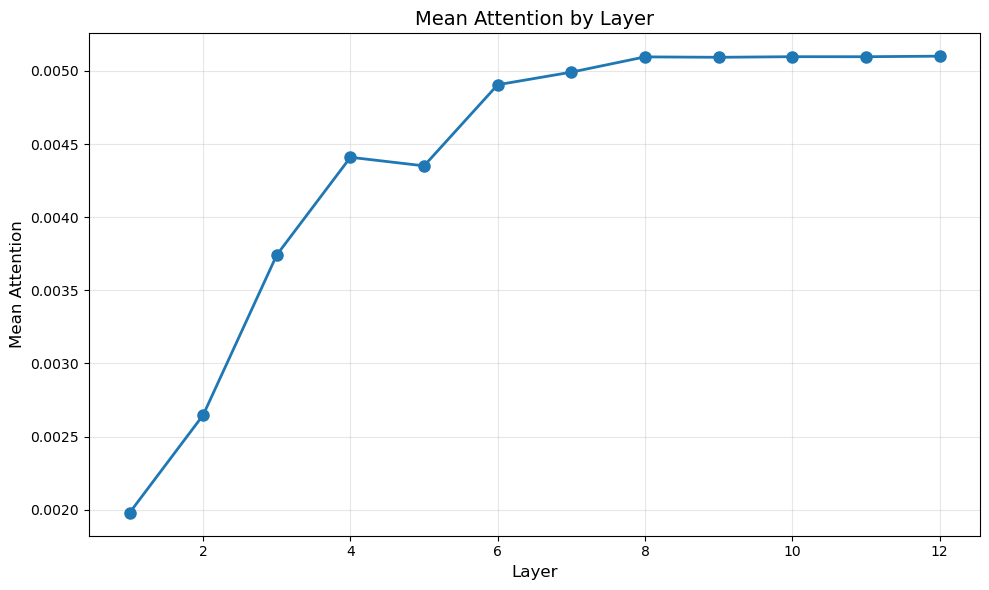

In [6]:
# 어텐션을 시각화해서 vit모델이 어떤 이미지(픽셀)에 집중하는지 확인해봄
# Attention Map         : 모델이 이미지의 어느 부분에 집중하는지
# Patch Embedding       : 이미지가 어떻게 작은 패치로 나누는지
# Positional Encoding   : 위치정보가 어떻게 인코딩
# Feature Map           : 각 레이어에서 추출된 정보/특징

import torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModel

def visualize_attention(image_path, model_name = 'google/vit-base-patch16-224'):
    '''vit 어텐션 맵을 시각화'''
    print('\n[1단계]모델 로드중...')
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(
        model_name,
        output_attentions = True  # 어텐션 가중치 반환
    )
    model.eval()
    print(f'모델 : {model_name}')

    print("\n[2단계] 이미지 로드 및 전처리 중....")
    if image_path.startswith('http'):
        image = Image.open(requests.get(image_path, stream=True).raw)
    else:
        image = Image.open(image_path)
    print(f'원본 이미지 크기 : {image.size}')

    inputs =  image_processor(image,return_tensors='pt')
    print(f"전처리 후 텐서 크기 : {inputs['pixel_values'].shape}")

    print('\n[3단계] 모델 추론 중.....')
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 어텐션 가중치 추출
    attentions =  outputs.attentions  # 각 레이어의 어텐션
    print(f'레이어 수 : {len(attentions)}')
    print(f'어텐션 텐서 크기 : {attentions[0].shape}')  
    print('batch size\tattention heads\tsequence lenghth')

    print(f'\n[4단계] 어텐션 맵 시각화 중....')
    # 마지막 레이어의 어텐션 사용
    last_attention = attentions[-1][0] #(num_head, seq_len, seq_len)

    # cls토큰이 다른 패치들에 주목하는 정도
    cls_attention = last_attention.mean(dim=0)[0,1:]  # 패치부분만

        # 어텐션을 2D 그리드로 재구성
    num_patches = int(np.sqrt(len(cls_attention)))
    attention_map = cls_attention.reshape(num_patches, num_patches).numpy()
    
    # 원본 이미지 크기로 리사이즈
    attention_map_resized = np.array(
        Image.fromarray(attention_map).resize(image.size, Image.BICUBIC)
    )
    
    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 원본 이미지
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # 어텐션 맵
    axes[1].imshow(attention_map, cmap='hot', interpolation='nearest')
    axes[1].set_title("Attention Map (Patch Level)")
    axes[1].axis('off')
    
    # 오버레이
    axes[2].imshow(image)
    axes[2].imshow(attention_map_resized, cmap='hot', alpha=0.5)
    axes[2].set_title("Attention Overlay")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('vit_attention_visualization.png', dpi=150, bbox_inches='tight')
    print("시각화 저장 완료: vit_attention_visualization.png")
    
    # 헤드별 어텐션 분석
    print("\n[5단계] 헤드별 어텐션 분석...")
    
    num_heads = last_attention.shape[0]
    print(f"어텐션 헤드 수: {num_heads}")
    
    # 각 헤드의 CLS 토큰 어텐션 시각화
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for head_idx in range(min(num_heads, 12)):  # 처음 12개 헤드만
        head_attention = last_attention[head_idx][0, 1:]  # CLS token의 어텐션
        head_map = head_attention.reshape(num_patches, num_patches).numpy()
        
        axes[head_idx].imshow(head_map, cmap='hot', interpolation='nearest')
        axes[head_idx].set_title(f"Head {head_idx + 1}")
        axes[head_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('vit_attention_heads.png', dpi=150, bbox_inches='tight')
    print(" 헤드별 시각화 저장 완료: vit_attention_heads.png")
    
    # 레이어별 어텐션 패턴 분석
    print("\n[6단계] 레이어별 어텐션 패턴 분석...")
    
    layer_attention_means = []
    for layer_idx, attention in enumerate(attentions):
        # 각 레이어의 평균 어텐션 계산
        mean_attention = attention[0].mean(dim=0)[0, 1:].mean().item()
        layer_attention_means.append(mean_attention)
        print(f"  Layer {layer_idx + 1}: 평균 어텐션 = {mean_attention:.4f}")
    
    # 레이어별 어텐션 플롯
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(layer_attention_means) + 1), layer_attention_means, 
             marker='o', linewidth=2, markersize=8)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Mean Attention', fontsize=12)
    plt.title('Mean Attention by Layer', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('vit_attention_by_layer.png', dpi=150, bbox_inches='tight')
    print(" 레이어별 분석 저장 완료: vit_attention_by_layer.png")    
    print("시각화 완료!")

test_img = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg'
visualize_attention(test_img)